# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [59]:
df[df['article_id'] == 1427.0]

,article_id,title,email
42,1427.0,"use xgboost, scikit-learn & ibm watson machine...",430bdfe1dd179eb05abc237d1f498bd5aa2f8fac
53,1427.0,"use xgboost, scikit-learn & ibm watson machine...",e654f8ce61fbb1e536a5eee4e490cdcb97f68077
60,1427.0,"use xgboost, scikit-learn & ibm watson machine...",b32cd4e1a74e55ac42e4ef484b1f0ad41ee3b1c5
61,1427.0,"use xgboost, scikit-learn & ibm watson machine...",04280117a1b04ca713602877bcac40230edbab65
68,1427.0,"use xgboost, scikit-learn & ibm watson machine...",a5e5a52ab275f02a72d5c2fa61687e73d895855a
...,...,...,...
45133,1427.0,"use xgboost, scikit-learn & ibm watson machine...",46fba43174c33f0fd84cea00568acaefaa7272ae
45363,1427.0,"use xgboost, scikit-learn & ibm watson machine...",09bfbea5158bc75b3cab965fce21c375a58b20f6
45644,1427.0,"use xgboost, scikit-learn & ibm watson machine...",b2aba86e922e9281aa8585e00eca77fdfe3449bc
45649,1427.0,"use xgboost, scikit-learn & ibm watson machine...",b2aba86e922e9281aa8585e00eca77fdfe3449bc


In [60]:
# Show df_content to get an idea of the data
df_content.tail()

,doc_body,doc_description,doc_full_name,doc_status,article_id
1051,PouchDB-find is a new API and syntax that allo...,PouchDB uses MapReduce as its default search m...,A look under the covers of PouchDB-find,Live,1046
1052,We compare discriminative and generative learn...,We compare discriminative and generative learn...,A comparison of logistic regression and naive ...,Live,1047
1053,"Essays about data, building products and boots...",In order to demystify some of the magic behind...,What I Learned Implementing a Classifier from ...,Live,1048
1054,NaN,Learn how to use IBM dashDB as data store for ...,Use dashDB with Spark,Live,1049
1055,Homepage Follow Sign in / Sign up Homepage * H...,Once you get used to developing in a Notebook ...,"Jupyter Notebooks with Scala, Python, or R Ker...",Live,1050


In [61]:
df_content['article_id'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1056 entries, 0 to 1055
Series name: article_id
Non-Null Count  Dtype
--------------  -----
1056 non-null   int64
dtypes: int64(1)
memory usage: 8.4 KB


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [62]:
# Group by email and count the number of articles each user has interacted with
user_article_counts = df.groupby('email')['article_id'].count()

# Descriptive statistics
print(user_article_counts.describe())

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64


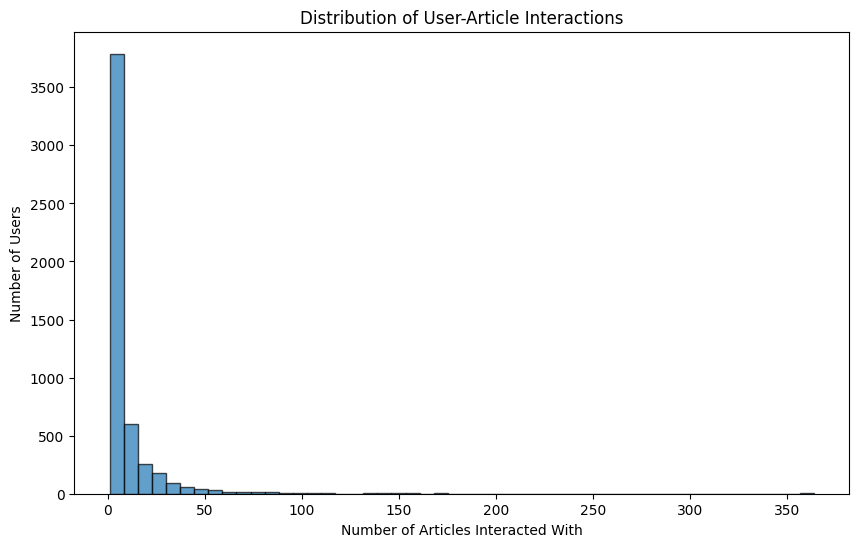

In [63]:
# Visualize with a histogram
plt.figure(figsize=(10, 6))
user_article_counts.hist(bins=50, edgecolor='k', alpha=0.7)
plt.title('Distribution of User-Article Interactions')
plt.xlabel('Number of Articles Interacted With')
plt.ylabel('Number of Users')
plt.grid(False)
plt.show()

In [64]:
# Calculate the median value of the number of articles users have interacted with.
median_val = user_article_counts.median()

# Print the median value.
print("Median value:", median_val)

# Calculate the max value of the number of articles users have interacted with.
max_views_by_user  = user_article_counts.max()

# Print the median value.
print("Max value:", max_views_by_user)

Median value: 3.0
Max value: 364


In [65]:
# Fill in the median and maximum number of user_article interactios below
print(f"50% of individuals interact with {median_val} number of articles or fewer.") # 50% of individuals interact with ____ number of articles or fewer.
print(f"The maximum number of user-article interactions by any 1 user is {max_views_by_user}") # max_views_by_user = # The maximum number of user-article interactions by any 1 user is ______.

50% of individuals interact with 3.0 number of articles or fewer.
The maximum number of user-article interactions by any 1 user is 364


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [66]:
# Confirm that duplicates are removed
print(f"Before removing duplicates, df_content has {df_content.shape[0]} articles.")

# Find and explore duplicate articles based on 'article_id'
duplicate_articles = df_content[df_content.duplicated(subset='article_id', keep='first')]

# Print the number of duplicate articles
print(f"There are {duplicate_articles.shape[0]} duplicate articles.")

Before removing duplicates, df_content has 1056 articles.
There are 5 duplicate articles.


In [67]:
# Remove any rows that have the same article_id - only keep the first
df_content = df_content.drop_duplicates(subset='article_id', keep='first')

# Confirm that duplicates are removed
print(f"After removing duplicates, df_content has {df_content.shape[0]} articles.")

After removing duplicates, df_content has 1051 articles.


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [68]:
# The number of unique articles that have at least one interaction
unique_articles = df['article_id'].nunique() 

 # The number of unique articles on the IBM platform
total_articles = df_content['article_id'].nunique()

# The number of unique users
unique_users = df['email'].nunique() 

# The number of user-article interactions
user_article_interactions = df.shape[0]

In [69]:
# The number of unique articles that have at least one interaction
print(f"There are {unique_articles} unique articles that have at least one interaction.")

# The number of unique articles on the IBM platform
print(f"There are {total_articles} articles on the IBM platform.")

# The number of unique users
print(f"There are {unique_users} unique users.")

# The number of user-article interactions
print(f"There are {user_article_interactions} user-article interactions.")

There are 714 unique articles that have at least one interaction.
There are 1051 articles on the IBM platform.
There are 5148 unique users.
There are 45993 user-article interactions.


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [70]:
# Group by 'article_id', count the interactions, and sort in descending order
article_interactions = df.groupby('article_id').size().sort_values(ascending=False)

# Get the most viewed article_id and its count
most_viewed_article_id = str(article_interactions.idxmax())
max_views = article_interactions.max()

# Ensure the article ID is formatted with one value following the decimal
most_viewed_article_id = "{:.1f}".format(float(most_viewed_article_id))

# Print the most viewed article_id and its view count
print(f"The most viewed article_id is {most_viewed_article_id} with {max_views} views.")


The most viewed article_id is 1429.0 with 937 views.


In [71]:
# most_viewed_article_id = # The most viewed article in the dataset as a string with one value following the decimal 
# max_views = # The most viewed article in the dataset was viewed how many times?

In [72]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [73]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [74]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    # Group by title, count the interactions, sort the values in descending order, and then take the top 'n' titles.
    top_articles = df.groupby('title').size().sort_values(ascending=False).head(n).index.tolist()
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    # Group by article_id, count the interactions, sort the values in descending order, and then take the top 'n' article_ids.
    top_articles = df.groupby('article_id').size().sort_values(ascending=False).head(n).index.tolist()
    
    # Convert the article IDs to strings, as specified
    top_articles = [str(id) for id in top_articles]
 
    return top_articles # Return the top article ids

In [75]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [76]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [77]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    # Using pivot_table to create a matrix of users and articles. 
    # Values will be 1 if there was an interaction, and NaN otherwise.
    user_item = df.pivot_table(index='user_id', columns='article_id', values='title', aggfunc='count').notnull().astype(int)
    
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

display(user_item)

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5146,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5147,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [78]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [79]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    similarity = user_item.dot(user_item.loc[user_id])

    # sort by similarity
    sorted_similarity = similarity.sort_values(ascending=False)
    
    # create list of just the ids
    most_similar_users = sorted_similarity.index.tolist()
   
    # remove the own user's id
    most_similar_users.remove(user_id)
    
    # return a list of the users in order from most to least similar
    return most_similar_users 
        

In [80]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [81]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    # Convert article_ids to float
    article_ids = [float(id) for id in article_ids]

    article_names = df[df['article_id'].isin(article_ids)]['title'].drop_duplicates().tolist()
    
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    # Retrieve article IDs that the user has interacted with
    article_ids = user_item.columns[user_item.loc[user_id] == 1].tolist()
    
    # Convert article IDs to string type
    article_ids = [str(float(aid)) for aid in article_ids] 

    # Retrieve article names
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    # Get a list of articles that the user has interacted with
    seen_ids, _ = get_user_articles(user_id)
    
    # Find similar users using our previous function
    similar_users = find_similar_users(user_id)
    
    recs = []
    for similar_user in similar_users:
        # Get articles interacted by similar user
        article_ids, _ = get_user_articles(similar_user)
        
        # Recommend articles that the user hasn't seen yet
        new_recs = [aid for aid in article_ids if aid not in seen_ids and aid not in recs]
        recs.extend(new_recs)
        
        # If we have enough recommendations
        if len(recs) >= m:
            break
    
    # Get only the top m recommendations
    recs = recs[:m]
    
    
    return recs # return your recommendations for this user_id    

In [82]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'timeseries data analysis of iot events by using jupyter notebook',
 'graph-based machine learning',
 'using brunel in ipython/jupyter notebooks',
 'experience iot with coursera',
 'the 3 kinds of context: machine learning and the art of the frame',
 'deep forest: towards an alternative to deep neural networks',
 'this week in data science (april 18, 2017)',
 'higher-order logistic regression for large datasets',
 'using machine learning to predict parking difficulty']

In [83]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [84]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    # Use the find_similar_users function to get the ordered list of similar users
    most_similar_users = find_similar_users(user_id, user_item)
    
    # Create a dataframe from this list
    neighbors_df = pd.DataFrame(most_similar_users, columns=['neighbor_id'])
    
    # Compute similarity values for these users and add it to the dataframe
    neighbors_df['similarity'] = neighbors_df['neighbor_id'].apply(lambda x: user_item.loc[user_id].dot(user_item.loc[x]))
    
    # Calculate number of interactions for each user and add it to the dataframe
    interactions = df.groupby('user_id')['article_id'].count()
    neighbors_df['num_interactions'] = neighbors_df['neighbor_id'].apply(lambda x: interactions[x])
    
    # Sort the dataframe by similarity and then by number of interactions
    neighbors_df = neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=[False, False])
    
    # Return the dataframe specified in the doc_string
    return neighbors_df 


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    # Get neighbors using get_top_sorted_users function
    neighbors_df = get_top_sorted_users(user_id)
    
    # Get articles the user has seen
    user_articles_ids, _ = get_user_articles(user_id)
    user_articles_ids = set(user_articles_ids)
    
    # Get the top articles (by total interactions) in the dataset for sorting the recommendations
    all_top_articles = get_top_article_ids(df['article_id'].nunique(), df)
    
    # Initialize recommendations
    recs = []

    # Loop through the users based on closeness to the input user_id
    for neighbor in neighbors_df['neighbor_id']:
        if len(recs) >= m:
            break

        # Get articles seen by the neighbor
        neighbor_articles, _ = get_user_articles(neighbor)
        neighbor_articles = set(neighbor_articles)

        # Find articles that the given user hasn't seen but the neighbor has
        new_recs = list(neighbor_articles - user_articles_ids)
        
        # Sort these new recommendations by their overall popularity
        new_recs = sorted(new_recs, key=lambda x: all_top_articles.index(str(x)))

        # Add these articles to the recommendation list
        recs.extend(new_recs)

        # Ensure recommendations are unique and not more than m
        recs = list(dict.fromkeys(recs))[:m]

    # Get article names for the recommendations
    rec_names = get_article_names(recs)
        
    return recs, rec_names

In [85]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1330.0', '1427.0', '1364.0', '1170.0', '1162.0', '1304.0', '1351.0', '1160.0', '1354.0', '1368.0']

The top 10 recommendations for user 20 are the following article names:
['apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'putting a human face on machine learning', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'model bike sharing data with spss', 'analyze accident reports on amazon emr spark', 'movie recommender system with spark machine learning']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [86]:
### Tests with a dictionary of results

user1_most_sim = find_similar_users(1)[0] # Find the user that is most similar to user 1 
user131_10th_sim = find_similar_users(131)[9] # Find the 10th most similar user to user 131

print(user1_most_sim)
print(user131_10th_sim)

3933
3910


In [87]:
# ## Dictionary Test Here
# sol_5_dict = {
#     'The user that is most similar to user 1.': user1_most_sim, 
#     'The user that is the 10th most similar to user 131': user131_10th_sim,
# }

# t.sol_5_test(sol_5_dict)

`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**

The find_similar_users function isn't suitable for new users due to the absence of their interaction data. In contrast, get_top_articles and get_top_article_ids are appropriate as they recommend top articles based on global popularity, making them fitting for users without personalized data.

For enhanced accuracy, implementing Knowledge-based or content-based recommendations is advisable. By initially collecting data on a new user's article category or topic preferences, we can tailor recommendations more closely to their interests.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [88]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10) # Your recommendations here



In [89]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [90]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

def make_content_recs(article_id, df, df_content, m=10):
    '''
    INPUT:
    article_id - (str) an article id from df
    df - (pandas dataframe) dataframe with article interactions
    df_content - (pandas dataframe) dataframe with article content descriptions
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    
    Description:
    For the provided article ID, this function first fetches its title from df.
    It then searches the df_content for this title in the 'doc_description'.
    If a match is found, it uses TF-IDF and cosine similarity to compute similarity scores,
    and then recommends articles that have similar content to this description.
    If the title doesn't exist in df_content, it treats the title as a search term and finds articles with similar descriptions.
    '''
    
    # Fetch the title for the given article_id from df
    article_title = df[df['article_id'] == float(article_id)]['title'].iloc[0]
    
    # Remove NaNs from df_content
    df_content = df_content.dropna(subset=['doc_description'])
    
    # Initialize the TF-IDF vectorizer
    tfidf = TfidfVectorizer(stop_words='english')
    
    # Construct the TF-IDF matrix by fitting and transforming the data
    tfidf_matrix = tfidf.fit_transform(df_content['doc_description'])
    
    # Compute the cosine similarity matrix
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
    
    # Try to find the article by title in df_content
    indices = df_content[df_content['doc_description'].str.contains(article_title, case=False, na=False)].index
    
    # If the title exists in df_content's doc_description, use the found index
    if len(indices) > 0:
        idx = indices[0]
    # If not, compute the TF-IDF for the title and find the most similar articles
    else:
        # Compute the similarity values of the article title to all doc_descriptions
        title_vector = tfidf.transform([article_title])
        cosine_sim_title = linear_kernel(title_vector, tfidf_matrix).flatten()
        # Use this similarity for recommendations
        sim_scores = list(enumerate(cosine_sim_title))
        # Sort the articles based on the similarity scores
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        # Get the scores of the m most similar articles
        sim_scores = sim_scores[:m]
        # Get the article indices
        article_indices = [i[0] for i in sim_scores]
        # Return the top m most similar articles
        return df_content['article_id'].iloc[article_indices].tolist()

    # If the title exists in df_content's doc_description, continue with the initial approach
    sim_scores = list(enumerate(cosine_sim[idx]))
    # Sort the articles based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Get the scores of the m most similar articles
    sim_scores = sim_scores[1:m+1]
    # Get the article indices
    article_indices = [i[0] for i in sim_scores]
    # Return the top m most similar articles
    return df_content['article_id'].iloc[article_indices].tolist()





`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

The content-based recommender system relies primarily on the textual content of articles, using either the doc_description or, if absent, the title. Its core functions include:

1. Text Processing with TF-IDF: Articles are transformed into a matrix of numerical values using the Term Frequency-Inverse Document Frequency (TF-IDF) technique. This matrix accentuates words that are common in a single article but not across the entire dataset, thereby emphasizing the uniqueness of each article.

2. Cosine Similarity Computation: After converting articles into their numerical representations, the system computes similarity scores between them using cosine similarity. This results in a matrix where the value at index (i, j) indicates the similarity between article i and article j.

3. Recommendation Retrieval: The system first determines an article's relevance either via its description or its title when the former isn't available. With this reference point, the system then finds and recommends the top 'm' articles that have the most significant similarity scores.

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [91]:
article_id = 1427.0

#  Check and display from df
if article_id in df['article_id'].values:
    print("Title from 'df' for article_id 1427.0:")
    display(df[df['article_id'] == article_id]['title'].iloc[0])
else:
    print("No information found in 'df' for article_id 1427.0.")

# Check and display from df_content
if article_id in df_content['article_id'].values:
    print("\nInformation from 'df_content' for article_id 1427.0:")
    display(df_content[df_content['article_id'] == article_id].iloc[0])
else:
    print("\nNo information found in 'df_content' for article_id 1427.0.")

Title from 'df' for article_id 1427.0:


'use xgboost, scikit-learn & ibm watson machine learning apis'


No information found in 'df_content' for article_id 1427.0.


In [92]:
# make recommendations for a brand new user
# This will get the top 10 article ids
new_user_recs = get_top_article_ids(10)

# get the associated article names
get_article_names(new_user_recs)

['healthcare python streaming application demo',
 'use deep learning for image classification',
 'apache spark lab, part 1: basic concepts',
 'predicting churn with the spss random tree algorithm',
 'analyze energy consumption in buildings',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'gosales transactions for logistic regression model',
 'insights from new york car accident reports',
 'finding optimal locations of new store using decision optimization']

In [93]:
# make a recommendations for a user who only has interacted with article id '1427.0'
recs_for_1427 = make_content_recs('1427.0', df, df_content, 10)

# get the associated article names
get_article_names(recs_for_1427)


['machine learning for everyone',
 'ibm watson machine learning: get started',
 'score a predictive model built with ibm spss modeler, wml & dsx',
 'use the machine learning library',
 "feature importance and why it's important",
 'data science experience documentation',
 'continuous learning on watson',
 'create a project for watson machine learning in dsx']

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [94]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [95]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In the lesson we also used FunkSVD as a new method to be useful for matrices with missing values. 

In [96]:
import numpy as np

# Perform SVD on the User-Item Matrix Here
# use the built in to get the three matrices
u, s, vt = np.linalg.svd(user_item_matrix, full_matrices=True)

**Provide your response here.**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

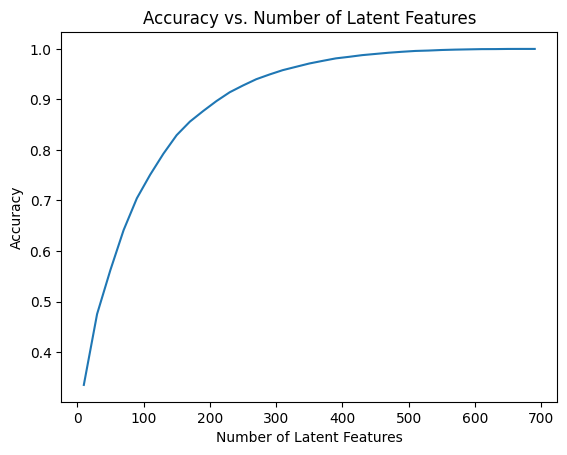

In [97]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [98]:
# from sklearn.model_selection import train_test_split

# df_train, df_test = train_test_split(df, test_size=5993, random_state=42)

df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    # Create user-item matrices for train and test datasets
    user_item_train = df_train.groupby(['user_id', 'article_id']).size().unstack().notnull().astype(int)
    user_item_test = df_test.groupby(['user_id', 'article_id']).size().unstack().notnull().astype(int)

    # Extract user and article ids for the test set
    test_idx = user_item_test.index.tolist()
    test_arts = user_item_test.columns.tolist()

    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [99]:
# Users in both train and test sets (i.e., users we can make predictions for)
common_users = user_item_train.index.isin(test_idx).sum()

# Articles in both train and test sets (i.e., articles we can make predictions for)
common_articles = user_item_train.columns.isin(test_arts).sum()

print(f"We can make predictions for {common_users} users in the test set.")
print(f"We can't make predictions for {len(test_idx) - common_users} users because of the cold start problem.")
print(f"We can make predictions for {common_articles} articles in the test set.")
print(f"We can't make predictions for {len(test_arts) - common_articles} articles because of the cold start problem.")

We can make predictions for 20 users in the test set.
We can't make predictions for 662 users because of the cold start problem.
We can make predictions for 574 articles in the test set.
We can't make predictions for 0 articles because of the cold start problem.


In [100]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


# sol_4_dict = {
#     'How many users can we make predictions for in the test set?': c # letter here, 
#     'How many users in the test set are we not able to make predictions for because of the cold start problem?': a # letter here, 
#     'How many articles can we make predictions for in the test set?': b # letter here,
#     'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d # letter here
# }

# t.sol_4_test(sol_4_dict)

`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [101]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below

In [102]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

# Identify the common users and articles:
# Get user and article ids from the training set
train_idx = user_item_train.index
train_arts = user_item_train.columns

# Find common users and articles
common_users = list(set(train_idx) & set(test_idx))
common_articles = list(set(train_arts) & set(test_arts))

In [103]:
# Adjust the matrices
u_test = u_train[user_item_train.index.isin(test_idx), :]
vt_test = vt_train[:, user_item_train.columns.isin(test_arts)]

In [104]:
# Make predictions using reduced matrices:
num_latent_feats = np.arange(10,700+10,20)
sum_errs_train = []
sum_errs_test = []

for k in num_latent_feats:
    # restructure with k latent features
    s_train_new, u_train_new, vt_train_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_new, vt_test_new = u_test[:, :k], vt_test[:k, :]
    
    # take dot product for train and test sets
    user_item_train_preds = np.around(np.dot(np.dot(u_train_new, s_train_new), vt_train_new))
    user_item_test_preds = np.around(np.dot(np.dot(u_test_new, s_train_new), vt_test_new))
    
    # compute error for each prediction to actual value for both train and test sets
    diffs_train = np.subtract(user_item_train, user_item_train_preds)
    diffs_test = np.subtract(user_item_test.loc[common_users, common_articles], user_item_test_preds)
    
    # total errors and keep track of them
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    
    sum_errs_train.append(err_train)
    sum_errs_test.append(err_test)


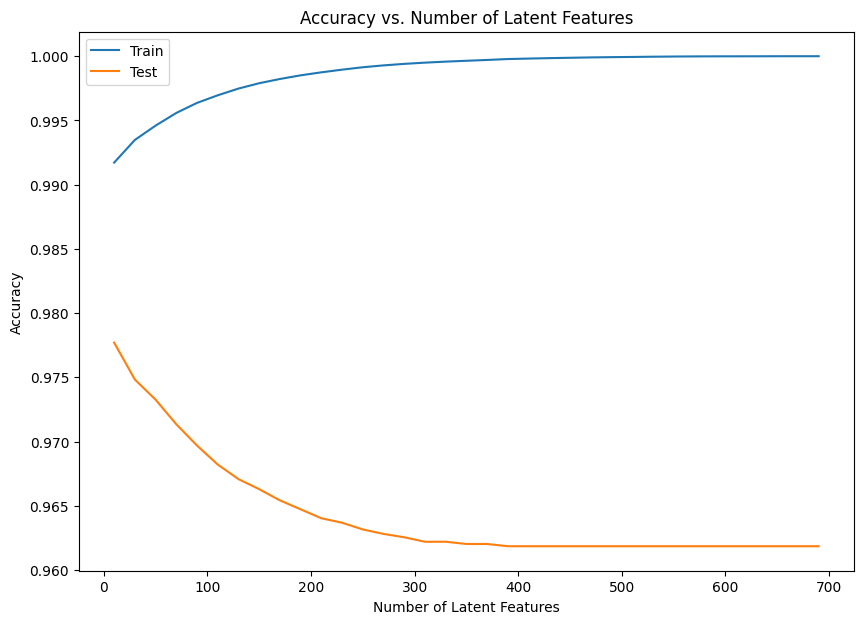

In [105]:
#  Plot the accuracies:
plt.figure(figsize=(10, 7))
plt.plot(num_latent_feats, 1 - np.array(sum_errs_train)/(user_item_train.shape[0]*user_item_train.shape[1]), label='Train')
plt.plot(num_latent_feats, 1 - np.array(sum_errs_test)/(len(common_users)*len(common_articles)), label='Test')
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features')
plt.legend()
plt.show()


The accuracy increases with the number of latent features for the training data but decreases for the test data, it suggests that the model might be overfitting to the training data. Having more latent features means the model will capture more nuances in the training data, but it might not generalize well to unseen data.

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Your response here.**

To determine if the recommendations are an improvement over the current system:

A/B Testing: Randomly assign users to two groups: one that receives recommendations from the current system (control group) and another that receives recommendations from the new system (experiment group). Measure the interaction rates (e.g., click-through rate) and compare between the two groups.

User Surveys: Get feedback directly from users. After showing recommendations, ask users for feedback on the relevance and quality of the recommendations. This can give qualitative insights that purely numerical metrics might miss.

Diversity and Coverage Metrics: Apart from accuracy, measure the diversity of recommendations and the coverage of articles recommended. A good recommendation system should not only be accurate but also diverse in its recommendations.

Monitor Long-Term Engagement: The true success of a recommendation system is seen in long-term user engagement. Monitor metrics like user retention, frequency of returning users, and time spent on recommended articles over an extended period.

In [106]:
def get_recommendations_for_user(user_id, df, user_item_matrix, u, s, vt, df_content, k, n=10):
    """
    Return the top article recommendations for a given user.
    Uses a combination of SVD and content-based recommendation.
    """

    # If user is new:
    if user_id not in user_item_matrix.index:
        return get_top_article_ids(n, df)

    # Use matrix factorization (SVD) to get article predictions for the user
    user_idx = np.where(user_item_matrix.index == user_id)[0][0]
    
    # restructure with k latent features
    s_k, u_k, vt_k = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # Predict ratings for the user
    user_predictions = np.dot(np.dot(u_k[user_idx, :], s_k), vt_k)
    
    # Get the article indices sorted by predicted rating
    article_idxs = user_predictions.argsort()[::-1]
    
    # Get content-based recommendations using the top article from SVD
    top_article_id = user_item_matrix.columns[article_idxs[0]]
    content_recs = make_content_recs(top_article_id, df, df_content, m=n)
    
    # Combine the recommendations
    all_recs = list(set(article_idxs[:n]) | set(content_recs))
    
    # Return only the top n recommendations
    return all_recs[:n]


user_id = 2
recommended_articles = get_recommendations_for_user(user_id, df, user_item_matrix, u, s, vt, df_content, k=150, n=10)

get_article_names(recommended_articles)

['simple graphing with ipython and\xa0pandas',
 "feature importance and why it's important",
 'continuous learning on watson',
 'create a project for watson machine learning in dsx']

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [107]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

1